Load in necessary libraries.

In [1]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

Load in the data, and create pool for speeding up computation.

In [2]:
data = pd.read_table("./l_tarentolae.tsv").dropna()
data.describe()

,Position,Fold Change,IPD Top Ratio,IPD Bottom Ratio
count,3.189589e+07,3.189589e+07,3.189589e+07,3.189589e+07
mean,5.865792e+05,5.956419e+00,1.157351e+00,1.157011e+00
std,4.944855e+05,6.495569e+01,4.157421e-01,4.180531e-01
min,6.000000e+00,8.835123e-02,0.000000e+00,0.000000e+00
25%,2.244970e+05,6.631389e-01,9.109886e-01,9.091598e-01
50%,4.571250e+05,9.848891e-01,1.082458e+00,1.081414e+00
75%,8.050280e+05,1.435938e+00,1.304344e+00,1.304364e+00
max,2.673707e+06,8.296673e+03,6.431390e+01,4.675641e+01


Define method to visualize a table, then examine a single chromsome

<IPython.core.display.Javascript object>


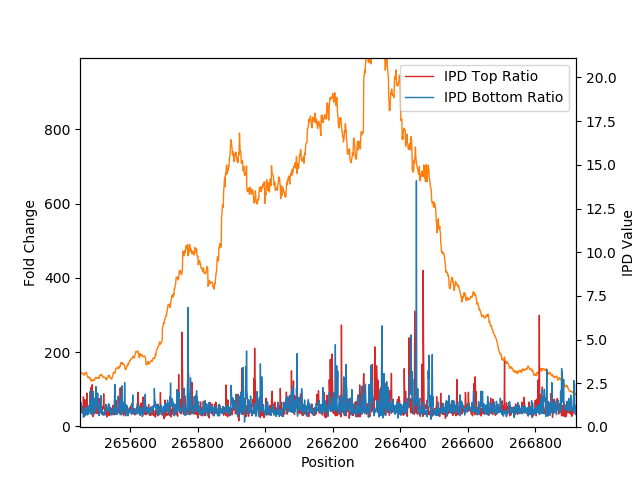

In [11]:
def plot_na(table, ax):
    color = "tab:grey"
    positions = table["Position"]
    if positions.iloc[0] != 0:
        ax.axvspan(0, positions.iloc[0], alpha=.5, facecolor=color)
    for i in range(1, positions.size):
        if positions.iloc[i] - positions.iloc[i-1] > 1:
            ax.axvspan(positions.iloc[i-1], positions.iloc[i], alpha=.5, facecolor=color)

def plot(table):
    # Set up a plot for the Fold Change
    color = "tab:orange"
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Fold Change')
    ax1.plot(table["Position"], table["Fold Change"], color=color, label="Fold Change", linewidth=1.0)
    ax1.tick_params(axis='y')

    # Create a second plot that shares the same x axis
    ax2 = ax1.twinx()

    # Set up the plot for the IPD Values
    color = "tab:red"
    ax2.set_ylabel("IPD Value")
    ax2.plot(table["Position"], table["IPD Top Ratio"], color=color, label="IPD Top Ratio", linewidth=1.0)
    color = "tab:blue"
    ax2.plot(table["Position"], table["IPD Bottom Ratio"], color=color, label="IPD Bottom Ratio", linewidth=1.0)
    ax2.tick_params(axis='y')
    
    plot_na(table, ax2)

    plt.legend()
    plt.show()


plot(data[data["Chromosome"] == "LtaP_01"])

# Cluster true positives vs. false positives.
# Color code by fold change
# Plot ALL peaks

# Redo figures, then do these.

Define a function to create a "window" of rows surrounding a specific row. This function also makes sure that the entire window does not contain any missing positions (e.g. no N/A values were contained)

In [10]:
def get_window(center, window_radius, table=data, filter_na=True):
    window = data[(data["Chromosome"] == center["Chromosome"])
                   & (data["Position"] >= center["Position"] - window_radius)
                   & (data["Position"] <= center["Position"] + window_radius)]
    return window if (len(window) == (2*window_radius+1)) or not filter_na else None

Check which values have high IPD values, and filter out the top J_WINDOWS that contain the full window we are looking at.

In [12]:
J_WINDOWS = 200
WINDOW_RADIUS = 100
IPD = 'IPD Top Ratio'

positives = data[data["Fold Change"] > 10].sort_values(by=[IPD], ascending=False)
j_windows = []
j_windows_rows = []
j_window_index = 0
while len(j_windows) < J_WINDOWS:
    window = get_window(positives.iloc[j_window_index], WINDOW_RADIUS, filter_na=False)
    if window is not None:
        j_windows_rows.append(window)
        j_windows.append(window[IPD])
        j_window_index += 1
    else:
        positives.drop(positives.index[j_window_index], inplace=True)

positives.head(5)

KeyboardInterrupt: 

Plot the largest positive

In [ ]:
plot(j_windows_rows[0])

Get the Fourier Analysis of the largest "Positive"

<IPython.core.display.Javascript object>


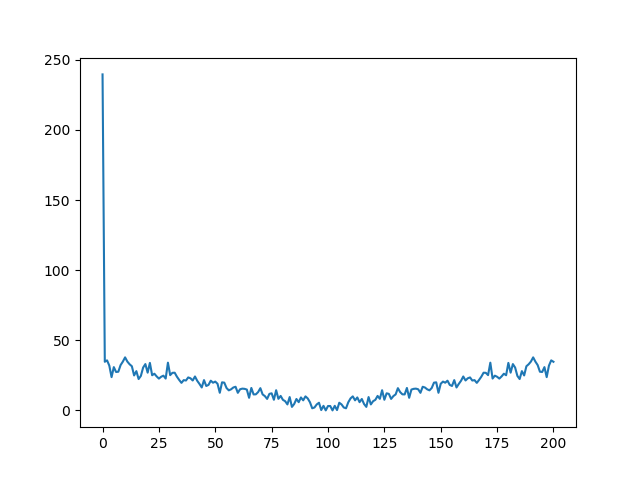

In [11]:
from scipy.fftpack import fft

j_window_f = fft(j_windows[0])

plt.plot(np.abs(np.real(j_window_f)))
plt.show()

# print(j_window_f)

Calculate the cross-correlation with the next largest positive.

0, 952.5098787294039


<IPython.core.display.Javascript object>


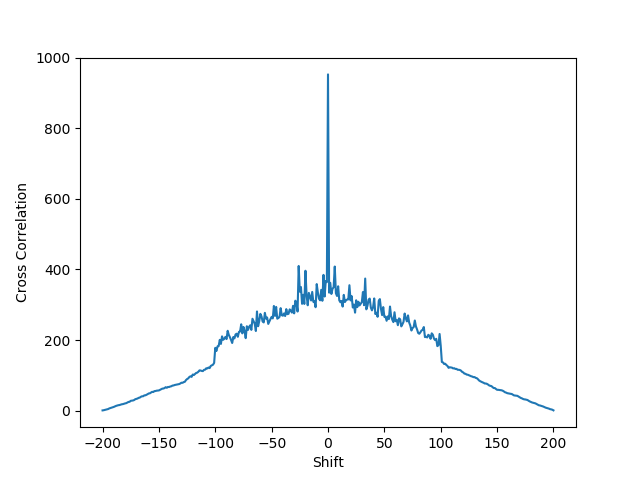

In [12]:
cc = np.correlate(j_windows[0], j_windows[1], "full")
cc_max = np.argmax(cc) - int(len(cc)/2)
print(str(cc_max) + ", " + str(cc[cc_max + int(len(cc)/2)]))
plt.plot([i - int(len(cc)/2) for i in range(len(cc))],cc)
plt.xlabel("Shift")
plt.ylabel("Cross Correlation")
plt.show()

Try averaging the peaks to see if there is some sort of pattern at the peaks (and somewhat filter out noise)

<IPython.core.display.Javascript object>


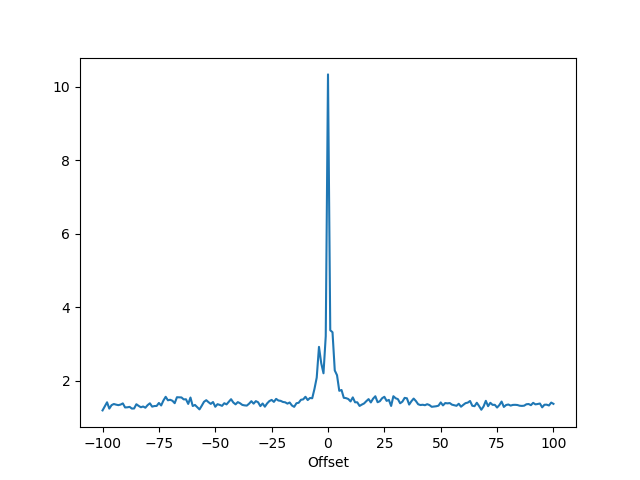

In [13]:
j_window_avg = np.sum(j_windows, axis=0) / J_WINDOWS

plt.plot([i - int(len(j_window_avg)/2) for i in range(len(j_window_avg))],
         j_window_avg)
plt.xlabel("Offset")
plt.show()

Plot overlayed histogram of the the IPD values on each base.

<IPython.core.display.Javascript object>


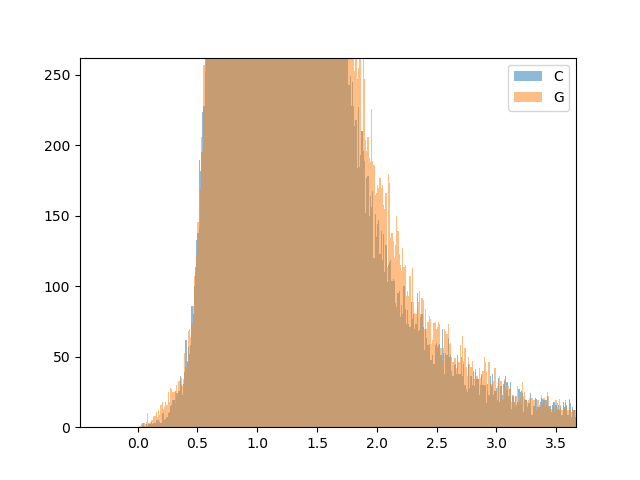

In [10]:
bins = np.linspace(0, 10, 1000)
pos = data[data["Fold Change"] > 10]
# plt.hist(pos[pos["Base"] == "A"]["IPD Top Ratio"], bins, alpha=.5, label="A")
# plt.hist(pos[pos["Base"] == "T"]["IPD Top Ratio"], bins, alpha=.5, label="T")
plt.hist(pos[pos["Base"] == "C"]["IPD Top Ratio"], bins, alpha=.5, label="C")
plt.hist(pos[pos["Base"] == "G"]["IPD Top Ratio"], bins, alpha=.5, label="G")
plt.legend()
plt.show()

# T, G, C similar
# A deviate